# Final Project

The dataset was obtained from [C3 AI Data lake](https://c3.ai/customers/covid-19-data-lake/).

# Table of Contents TBD
1. [Importing libraries](#Importing-libraries)
2. [Getting the first x-ray](#Getting-the-first-x-ray) 

    a. [Fetch diagnosis details](Fetch-Diagnosis-details)
3. [Data Preprocessing](#Store-dataset-locally)

    a. [Storing dataset locally](#Store-dataset-locally)
    b. [Resizing images](#Resizing-images)
4. [Principal Component Analysis](#fourth-examplehttpwwwfourthexamplecom)

    a. [PCA Neural Network](#PCA-Neural-Network)


## Importing libraries

Import the [requests](https://requests.readthedocs.io/en/master/), [pandas>=1.0.0](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/3.2.1/index.html), and [scipy](https://www.scipy.org/) libraries before using this notebook.

In [5]:
# Utils
import requests
import urllib.request
import pandas as pd
import numpy as np
import os.path
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib import pyplot as plt
from scipy.stats import gamma
from PIL import Image, ImageOps
from io import BytesIO
from PIL.ExifTags import TAGS
from os import path
from os import listdir
from os.path import isfile, join
from tensorflow import keras
from tensorflow.keras import layers
from numpy import percentile


# algorithms
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

# Image directory
imgDirectory = 'img/'
ctDir = 'ct_scan/'
frontalXRayDir = 'frontal_x-ray/'
sideXRayDir = 'sideways_x-ray/'
imgPath = f"{imgDirectory}{frontalXRayDir}gray/"
imgPath128 = f"{imgDirectory}{frontalXRayDir}128/gray/"

random_seed = 14061996

Ensure that you have a recent version of pandas (>= 1.0.0).

In [6]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.0.1


### Functions

A set of useful functions to be used later on

In [7]:
# https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap

# Display images in a grid-like fashion
def display_images(
    images: [PilImage], 
    columns=10, width=100, height=100, max_images=10, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

# Image exists in directory
def file_exists(fileId: str, directory: str):
    return os.path.exists(f"{directory}{fileId}")

# Returns either 'CT', 'FRONT', 'SIDE', np.nan depending if the image is in a specific directory or not existing
def getFileType(fileName: str):
    if file_exists(fileName, f"{imgDirectory}{ctDir}"):
        return 'CT'
    elif file_exists(fileName, f"{imgDirectory}{frontalXRayDir}"):
        return 'FRONT'
    elif file_exists(fileName, f"{imgDirectory}{sideXRayDir}"):
        return 'SIDE'
    return None

# Returns the width of an existing frontal xray in the xray directory
def getFileWidth(fileName: str):
    if (file_exists(fileName, f"{imgDirectory}{frontalXRayDir}")):
        width, height = Image.open(f"{imgDirectory}{frontalXRayDir}{fileName}").size
        return width
    else:
        return 0

# Returns the height of an existing frontal xray in the xray directory
def getFileHeight(fileName: str):
    if (file_exists(fileName, f"{imgDirectory}{frontalXRayDir}")):
        width, height = Image.open(f"{imgDirectory}{frontalXRayDir}{fileName}").size
        return height
    else:
        return 0

# https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
# Create an encoder and decoder
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Getting the first x-ray

The helper methods in `c3aidatalake.py` convert a JSON response from the C3.ai APIs to a Pandas DataFrame. You may wish to view the code in `c3aidatalake.py` before using the quickstart examples.

In [8]:
import c3aidatalake

### Fetch Diagnosis details

Following the documentation in: https://c3.ai/covid-19-api-documentation/#tag/Diagnosis, I make use of the c3aidatalake helper method to obtain the diagnosis dataset.

In [11]:
rawDiagnosis = c3aidatalake.fetch(
    "diagnosis",
    {
        "spec": {
            "filter": "contains(lowerCase(testResults), 'covid')"
        }
    }
)

rawDiagnosis

,imageUrl,source,idPatient,testResults,id,location.id,age,clinicalNotes,temperature
0,MONTREAL/images/00870a9c.jpg,Montreal,226,Pneumonia/Viral/COVID-19: positive,00870a9c.jpg,Hannover_Germany,NaN,NaN,NaN
1,MONTREAL/images/01E392EE-69F9-4E33-BFCE-E5C968...,Montreal,46,Pneumonia/Viral/COVID-19: positive,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Italy,55.0,"Woman, 55 years old, reports dyspnea for a few...",NaN
2,MONTREAL/images/03BF7561-A9BA-4C3C-B8A0-D3E585...,Montreal,77,Pneumonia/Viral/COVID-19: positive,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Italy,65.0,"Female patient, 65 years old, in a pathologica...",NaN
3,MONTREAL/images/071d06607edf81d70c940e043bce34...,Montreal,351,Pneumonia/Viral/COVID-19: positive,071d06607edf81d70c940e043bce34_jumbo.jpeg,UnitedKingdom,65.0,Presentation: SOB and myalgia.. Imaging Notes:...,NaN
4,MONTREAL/images/078d2e0b3e4fec1d603efb0e818c31...,Montreal,459,Pneumonia/Viral/COVID-19: positive,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Hungary,70.0,"DM, hypertension, congestive heart failure, ch...",NaN
...,...,...,...,...,...,...,...,...,...
1995,MONTREAL/images/radiol.2020200490.fig3.jpeg,Montreal,18,Pneumonia/Viral/COVID-19: positive,radiol.2020200490.fig3.jpeg,Jiangsu_China,53.0,Chest radiography of confirmed Coronavirus Dis...,NaN
1996,MONTREAL/images/radiol.2020201160.fig2a.jpeg,Montreal,151,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2a.jpeg,HongKong_China,NaN,NaN,NaN
1997,MONTREAL/images/radiol.2020201160.fig2b.jpeg,Montreal,152,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2b.jpeg,HongKong_China,NaN,NaN,NaN
1998,MONTREAL/images/radiol.2020201160.fig2c.jpeg,Montreal,153,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2c.jpeg,HongKong_China,NaN,NaN,NaN


From the diagnosis dataset I'm only interested on the id (the xray image filename), the idPatient representing a unique id per patient and the testResult for Pneumonia/Viral/COVID-19.

In [12]:
diagnosis = rawDiagnosis[['idPatient', 'id', 'testResults']]

print(f"Diagnosis length: {len(diagnosis)}")

examples = diagnosis.head(10)

examples

Diagnosis length: 2000


,idPatient,id,testResults
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
5,249,08d780ae.jpg,Pneumonia/Viral/COVID-19: positive
6,350a,08ed451c576ee00935ee178ec85c57_jumbo-1.jpeg,Pneumonia/Viral/COVID-19: positive
7,352,0a6c60063b4bae4de001caaba306d1_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
8,263,0a7faa2a.jpg,Pneumonia/Viral/COVID-19: positive
9,320,1-s2.0-S0085253820303616-gr1_lrg-a.png,Pneumonia/Viral/COVID-19: positive


The diagnosis dataset has an `id` column, representing the image id. The API allows to call for the images by `id`.

In [8]:
image_id = examples.loc[0, "id"] 
print(f"Image Id: {image_id} \n")


image_urls = c3aidatalake.read_data_json(
    "diagnosis",
    "getimageurls",
    {
        "ids" : [image_id]
    }
)

url = image_urls["value"][image_id]["value"]

print(f"Real url of the image: \n {url} \n ")

Image Id: 00870a9c.jpg 

Real url of the image: 
 https://dti--prod-covid.s3.amazonaws.com/fs/covid/prod/MONTREAL/images/00870a9c.jpg?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEBUaCXVzLWVhc3QtMSJGMEQCIECjgdoQwFsqFbyubd5z1C7%2BUpgU2xdaYvSBxm1zKaTYAiAMQNQS9j1D7uCDKTUpAqWn5CiiKBldGYQTV12AZyJgqyq0Awh9EAMaDDIwOTkyMTYyOTU4NSIMsK3QCTNgSac5%2FNc4KpEDFev4uQDvm4wjiAUcz4fwJ2MQrIXIdFeaV8ZIZRi4ESAtvS0aLSXsXku6vaTy6WMrTTbK%2BDn3R538Qwpllsk788Mo74jEJPTJqEtuCEfEGGZ9O%2F3Hkv5MsJmpnrTdUlSg6Wa%2BrhFDXWBK8qjpFiy%2B60Z5uWuW7GfSHZ1ovuycH7qmEBDkVoID2nonjvyzE%2BwWYLziWhTGwrLmj19gofDzXgyuUwxIlA%2FDXdGJrLFcDQuJshKe2%2B29JW6VQjahhZWlZuslMhyC4KcoowTag9pNvd%2BxTU%2Bng8VcykiRsr7FKIpfpS9TBk9sP2x55KANE%2F2N867Ypy1pJkYvSVAUwTea6iMjdVKckMhACNhPUM9rmgPr0NVseok9Ob3%2F8R7w30VpXb2aJNPVSovCTrOwxMffQoeVIUeA5iKyyXHfKkD86hm5AbWEGHVSaoUqoV9wLRGx4ghYDWeqJfdzshlNAmvQ39iKYXy5itrzAcya9ZR1%2BkcMErHeqT2TT4JKsmFIe58pRDb8BTNBrn1qGLZd8qmmDIowi8f3gwY67AFGSmC51X3M6D4Vg5p6YsKw6qN2rlJX82tzNA7Av3AO%2BcT1JfPechJDjI3SMLqudG8P4bgZOJOtKAbzxSFgqaKo0TH

Checking the result of the real image url:

Image information: 
Width: 2000px Height: 2000px
The following image is rezised as it would take up a lot of space.


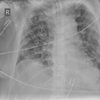

In [10]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))

print("Image information: ")
width, height = img.size
print(f"Width: {width}px Height: {height}px")
print("The following image is rezised as it would take up a lot of space.")
img.resize((100,100))

## Data Preprocessing

Need to store the images locally to avoid calls to the API and pre-process the images for the dimensionality reduction algorithms. Some work on the `diagnosis` object will be required, through normalizing things and ordering everything to be able to have proper training and testing sets.

In [13]:
idList = diagnosis['id'].to_numpy().tolist()
print(f"Length of id list: {len(idList)}")

Length of id list: 2000


### Storing dataset locally

Download and store the set of images locally, in order to avoid excesive requests to the API later on. If the images were already downloaded, no future calls to the API are performed.

In [10]:
print('Starting download...')

# Even though the c3ai spec states that an id array can be passed, the API limits the response and does not return an
# correct response, so an iterative inefficient approach was done.

for id in idList:
    file = f"{imgDirectory}{id}"
    # If file already exists in download directory, or if the id does not have a valid extension, do not download
    if (not path.exists(file)) and  ('.' in id):
        print(f"\t Downloading: {id}")
        try:
            # first request to get real url
            obj = c3aidatalake.read_data_json(
                "diagnosis",
                "getimageurls",
                {
                    "ids" : [id]
                }
            )
            # second request downloading from real url
            urllib.request.urlretrieve(obj['value'][id]['value'], file)
        # In case any 4xx or 5xx http error come up
        except urllib.error.HTTPError as exception:
            print(exception)

print('Finished download.')

Starting download...
	 Downloading: coronacases_org_001.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_002.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_003.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_004.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_005.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_006.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_007.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_008.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_009.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_010.nii.gz
HTTP Error 404: Not Found
Finished download.


Now, with the images downloaded under the `imgDirectory` path let's add additional columns with information about the images.

The dataset has both CT scans and frontal & side-ways chest x-rays. The analysis will be done on the mayoritary group of images, they are manually separated in different folders.


#### Frontal X-Ray example

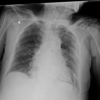

In [11]:
Image.open(f"{imgDirectory}{frontalXRayDir}0a6c60063b4bae4de001caaba306d1_jumbo.jpeg").resize((100,100))

#### Sideways chest x-ray

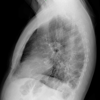

In [12]:
Image.open(f"{imgDirectory}{sideXRayDir}covid-19-pneumonia-20-l-on-admission.jpg").resize((100,100))

#### CT Scan example

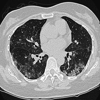

In [13]:
Image.open(f"{imgDirectory}{ctDir}1-s2.0-S0929664620300449-gr3_lrg-c.jpg").resize((100,100))

In [14]:
# List of downloaded images
ctList = [f for f in listdir(f"{imgDirectory}{ctDir}") if isfile(join(f"{imgDirectory}{ctDir}", f))]
frontalXRayList = [f for f in listdir(f"{imgDirectory}{frontalXRayDir}") if isfile(join(f"{imgDirectory}{frontalXRayDir}", f))]
sideXRayList = [f for f in listdir(f"{imgDirectory}{sideXRayDir}") if isfile(join(f"{imgDirectory}{sideXRayDir}", f))]


print(f"Length ct scans: {len(ctList)}")
print(f"Length frontal xrays: {len(frontalXRayList)}")
print(f"Length side xrays: {len(sideXRayList)}")

Length ct scans: 43
Length frontal xrays: 475
Length side xrays: 26


Let's make a dataframe that shows this information and allows to filter only the frontal xray rows.

In [14]:
df = pd.DataFrame(diagnosis)
df['imageType'] = df['id'].apply(lambda x: getFileType(x))
df

,idPatient,id,testResults,imageType
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT


Check that the new column values corresponds to the images in the directories

In [16]:
ctA, ctB = df[df.imageType.eq('CT')].shape
fA, fB = df[df.imageType.eq('FRONT')].shape
sA, sB = df[df.imageType.eq('SIDE')].shape
nA, nB = df[df.imageType.isnull()].shape

print(f"Length ct scan: {ctA}")
print(f"Length front xray: {fA}")
print(f"Length side xray: {sA}")
print(f"Length NAN: {nA}")

Length ct scan: 43
Length front xray: 474
Length side xray: 26
Length NAN: 1457


Out of the 2000 original rows, 1457 need to be left out due to their images not being valid (either because of invalid extension, corrupted, or unable to access the remote host to download them).

From the remaining 543 images, 43 belong to ct scans and 26 belong to sideways x-rays, so they are left out as well. 474 frontal x-rays remain in the dataframe.

In [15]:
df = df[df['imageType'] == 'FRONT']
df

,idPatient,id,testResults,imageType
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT


In [18]:
ctA, ctB = df[df.imageType.eq('CT')].shape
fA, fB = df[df.imageType.eq('FRONT')].shape
sA, sB = df[df.imageType.eq('SIDE')].shape
nA, nB = df[df.imageType.isnull()].shape

print(f"Length ct scan: {ctA}")
print(f"Length front xray: {fA}")
print(f"Length side xray: {sA}")
print(f"Length NAN: {nA}")

Length ct scan: 0
Length front xray: 474
Length side xray: 0
Length NAN: 0


### Resizing

The images will not be resized to 256x256 resolution, but as not all the images are of the same size, the lowest resolution will be picked and all images will be resized to that size. The minimun resolution needs to be higher than 256x256.

Two new columns are created, one with the width and another one with the height if the specified image.

In [16]:
df['width'] = df['id'].apply(lambda x: getFileWidth(x))
df['height'] = df['id'].apply(lambda x: getFileHeight(x))
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,idPatient,id,testResults,imageType,width,height
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT,2000,2000
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1989,1482
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1610,1632
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1024,817
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1024,750
...,...,...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1300,1343
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,906,798
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,894,799
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,842,835


In [17]:
print("5 number summary of width and height columns: \n")

width_quartiles = percentile(df['width'], [25, 50, 75])
width_min, width_max = df['width'].min(), df['width'].max()

height_quartiles = percentile(df['height'], [25, 50, 75])
height_min, height_max = df['height'].min(), df['height'].max()

print('Width: ')
print('\t Min: %.3f' % width_min)
print('\t Q1: %.3f' % width_quartiles[0])
print('\t Median: %.3f' % width_quartiles[1])
print('\t Q3: %.3f' % width_quartiles[2])
print('\t Max: %.3f' % width_max)

print('Height: ')
print('\t Min: %.3f' % height_min)
print('\t Q1: %.3f' % height_quartiles[0])
print('\t Median: %.3f' % height_quartiles[1])
print('\t Q3: %.3f' % height_quartiles[2])
print('\t Max: %.3f' % height_max)

5 number summary of width and height columns: 

Width: 
	 Min: 220.000
	 Q1: 770.500
	 Median: 1044.500
	 Q3: 2000.000
	 Max: 5623.000
Height: 
	 Min: 202.000
	 Q1: 692.000
	 Median: 1016.500
	 Q3: 2000.000
	 Max: 4757.000


Showing 10 images of 948:
No images to display.


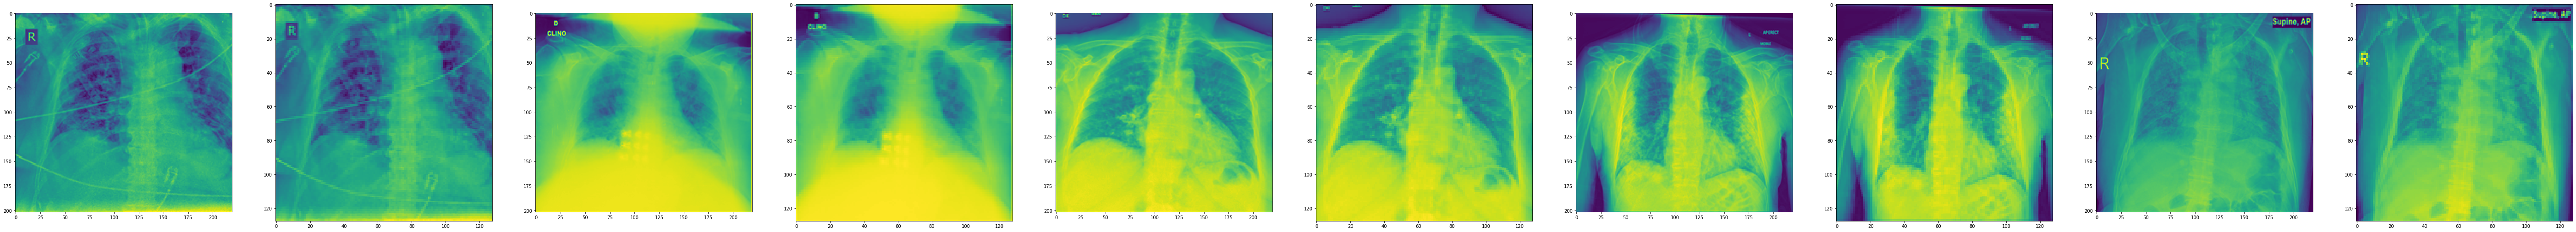

In [19]:
xRays = []
xRays128 = []
for index, path in enumerate(df['id']):
    originalImg = Image.open(f"{imgDirectory}{frontalXRayDir}{path}")
    grayScaledResizedImg = ImageOps.grayscale(originalImg).resize((220,202))
    grayScaledResizedImg128 = ImageOps.grayscale(originalImg).resize((128,128))
    grayScaledResizedImg.save(f"{imgDirectory}{frontalXRayDir}gray/{path}")
    grayScaledResizedImg128.save(f"{imgDirectory}{frontalXRayDir}128/gray/{path}")
    xRays.append(grayScaledResizedImg)
    xRays.append(grayScaledResizedImg128)
display_images(xRays)

The frontal xray images are now stored in `img/frontal_x-ray/gray/`, with a Width and Height of 220x202 and grayscaled to standarize the dataset.

The same images are stored in `img/frontal_x-ray/128/gray`, with a Width and Height of 128x128 and grayscaled to standarize the dataset.

The last part of the "pre-processing" is to change the testResults from a `String` to a `boolean`, just to simplify it.

In [20]:
df['testResults'] = df['testResults'].apply(lambda x: 'positive' in x)
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,idPatient,id,testResults,imageType,width,height
0,226,00870a9c.jpg,True,FRONT,2000,2000
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,True,FRONT,1989,1482
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,True,FRONT,1610,1632
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,True,FRONT,1024,817
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,True,FRONT,1024,750
...,...,...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,True,FRONT,1300,1343
1996,151,radiol.2020201160.fig2a.jpeg,True,FRONT,906,798
1997,152,radiol.2020201160.fig2b.jpeg,True,FRONT,894,799
1998,153,radiol.2020201160.fig2c.jpeg,True,FRONT,842,835


The flattened images are needed for the following dimensionality reduction algorithms.

In [96]:
flattenedImgs = []
for id in df['id']:
    flattenedImgs.append(np.asarray(Image.open(f"{imgPath}{id}")).flatten())

print("220x202 shape: ")
print(flattenedImgs[0].shape)

imgs128 = []
for id in df['id']:
    imgs128.append(np.asarray(Image.open(f"{imgPath128}{id}")))

print("\n128x128 shape: ")
print(imgs128[0].shape)

220x202 shape: 
(44440,)


TypeError: dispatcher for __array_function__ did not return an iterable

## Principal Component Analysis

PCA is applied to the resulting set of images. The images are flattened from a numpy array. Using PCA library from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.get_params 

In [30]:
pca = PCA(n_components=0.8)


pca.fit(flattenedImgs)
print("===========")
print("Start Fit stats")
print("N components")
print(pca.n_components_)
print("\n")
print("Explained Variance")
print(pca.explained_variance_)
print("\n")
print("Explained Variance Ratio")
print(pca.explained_variance_ratio_)
print("End Fit stats")
print("===========")
transformedImgs = pca.transform(flattenedImgs)


#Separate in train and test sets

x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(transformedImgs, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

#shapes
print("Shapes\n")
print("x_pca_train shape: ")
print(x_pca_train.shape)
print("x_pca_test shape: ")
print(x_pca_test.shape)
print("y_pca_train shape: ")
print(y_pca_train.shape)
print("y_pca_test shape: ")
print(y_pca_test.shape)

Start Fit stats
N components
19


Explained Variance
[29623076.03301834 12442154.34858783  8011657.63633308  5395206.57983522
  3907498.67054595  3108339.42409618  2555236.35240217  2038178.7809017
  1739156.68382256  1435814.83257259  1079547.33983529   975088.82492094
   904500.0479837    852570.83899233   803613.72321657   730311.20206323
   664213.98950382   630799.69045023   599470.34989945]


Explained Variance Ratio
[0.30779083 0.12927696 0.08324304 0.05605748 0.04059984 0.03229639
 0.02654952 0.02117716 0.01807025 0.01491846 0.01121675 0.01013141
 0.00939797 0.00885841 0.00834974 0.00758811 0.00690134 0.00655416
 0.00622864]
End Fit stats
Shapes

x_pca_train shape: 
(379, 19)
x_pca_test shape: 
(95, 19)
y_pca_train shape: 
(379,)
y_pca_test shape: 
(95,)


#### Create the model

In [31]:
inputsPCA = keras.Input(shape=(19,), name="images")
aux = layers.Dense(19, activation="relu", name="dense_1")(inputsPCA)
aux = layers.Dense(19, activation="relu", name="dense_2")(aux)
outputsPCA = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelPCA = keras.Model(inputs=inputsPCA, outputs=outputsPCA)

modelPCA.summary()

modelPCA.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 19)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                380       
_________________________________________________________________
predictions (Dense)          (None, 1)                 20        
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Train pca model

In [32]:
modelPCA.fit(x_pca_train, y_pca_train)

379/379 [==============================] - 0s 320us/sample - loss: 29.2364 - accuracy: 0.9182


#### Test the model

In [33]:
print("Evaluate on test data")
resultsPCA = modelPCA.evaluate(x_pca_test, y_pca_test)
print("test loss, test acc:", resultsPCA)

Evaluate on test data
95/95 [==============================] - 0s 274us/sample - loss: 0.0000e+00 - accuracy: 1.0000
test loss, test acc: [0.0, 1.0]


## t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is applied to the resulting set of images. Using the TSNE library from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

In [38]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2)

transformedImgs = tsne.fit_transform(flattenedImgs)

print("===========")
print("Start Fit stats")
print("\n")
print("N iterations")
print(tsne.n_iter_)
print("\n")
print("Kullback-Leibler divergence")
print(tsne.kl_divergence_)
print("End Fit stats")
print("===========")

x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test = train_test_split(transformedImgs, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

print("Shapes:\n")
print("x_tsne_train shape: ")
print(x_tsne_train.shape)
print("x_tsne_test shape: ")
print(x_tsne_test.shape)
print("y_tsne_train shape: ")
print(y_tsne_train.shape)
print("y_tsne_test shape: ")
print(y_tsne_test.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 474 samples in 0.463s...
[t-SNE] Computed neighbors for 474 samples in 11.352s...
[t-SNE] Computed conditional probabilities for sample 474 / 474
[t-SNE] Mean sigma: 2514.505617
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 72.2667236, gradient norm = 0.4932921 (50 iterations in 0.107s)
[t-SNE] Iteration 100: error = 73.0535965, gradient norm = 0.4607602 (50 iterations in 0.135s)
[t-SNE] Iteration 150: error = 72.5368958, gradient norm = 0.4736705 (50 iterations in 0.109s)
[t-SNE] Iteration 200: error = 72.9003296, gradient norm = 0.4636186 (50 iterations in 0.121s)
[t-SNE] Iteration 250: error = 73.1181717, gradient norm = 0.4896796 (50 iterations in 0.128s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.118172
[t-SNE] Iteration 300: error = 1.1473988, gradient norm = 0.0040902 (50 iterations in 0.112s)
[t-SNE] Iteration 350: error = 1.1024723, gradient norm = 0.00108

#### Create the t-SNe model

In [39]:
inputsTSNE = keras.Input(shape=(2,), name="images")
aux = layers.Dense(2, activation="relu", name="dense_1")(inputsTSNE)
aux = layers.Dense(2, activation="relu", name="dense_2")(aux)
outputsTSNE = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelTSNE = keras.Model(inputs=inputsTSNE, outputs=outputsTSNE)

modelTSNE.summary()

modelTSNE.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
predictions (Dense)          (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


#### Train the tsne model

In [40]:
modelTSNE.fit(x_tsne_train, y_tsne_train)

379/379 [==============================] - 0s 285us/sample - loss: 0.6666 - accuracy: 0.9156


#### Test the tsne model

In [41]:
print("Evaluate on test data")
resultsTSNE = modelTSNE.evaluate(x_tsne_test, y_tsne_test)
print("test loss, test acc:", resultsTSNE)

Evaluate on test data
95/95 [==============================] - 0s 333us/sample - loss: 0.6351 - accuracy: 1.0000
test loss, test acc: [0.6350802183151245, 1.0]


## Neural Net using 128x128 images

In [93]:
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(imgs128, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

print("Length:\n")
print("x_nn_train: ")
print(len(x_nn_train))
print("x_nn_test shape: ")
print(len(x_nn_test))
print("y_nn_train shape: ")
print(len(y_nn_train))
print("y_nn_test shape: ")
print(len(y_nn_test))


print(np.array(x_nn_train)[0].shape)

print(y_nn_train[0])

Length:

x_nn_train: 
379
x_nn_test shape: 
95
y_nn_train shape: 
379
y_nn_test shape: 
95
(128, 128)
True


In [91]:
inputsNN = keras.Input(shape=(128,128), name="images")
aux = layers.Dense(2, activation="relu", name="dense_1")(inputsNN)
aux = layers.Dense(2, activation="relu", name="dense_2")(aux)
outputsNN = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelNN = keras.Model(inputs=inputsNN, outputs=outputsNN)

modelNN.summary()

modelNN.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 128, 128)]        0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 2)            258       
_________________________________________________________________
dense_2 (Dense)              (None, 128, 2)            6         
_________________________________________________________________
predictions (Dense)          (None, 128, 1)            3         
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________


In [94]:
modelNN.fit(np.array(x_nn_train), y_nn_train)

ValueError: A target array with shape (379, 1) was passed for an output of shape (None, 128, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [95]:
print("Evaluate on test data")
resultsNN = modelNN.evaluate(x_nn_test, y_n_test)
print("test loss, test acc:", resultsnn)

Evaluate on test data


NameError: name 'y_n_test' is not defined